In [1]:
""" Image segmentation with a U-Net architecture to segment area with surface or hidden landmines in aerial thermal images

"""
"""
Trained an U-Net model on VisDrone2019 dataset on Tensorflow Framework Using Keras Functional API
Applied the trained U-Net model to segment images for hidden landmines in
LANDMINE THERMAL IMAGE SERIES Dataset
https://ieee-dataport.org/open-access/landmine-thermal-image-series files

Datasets used are downloaded in the local storage
"""

'\nTrained an U-Net model on VisDrone2019 dataset on Tensorflow Framework Using Keras Functional API\nApplied the trained U-Net model to segment images for hidden landmines in\nLANDMINE THERMAL IMAGE SERIES Dataset\nhttps://ieee-dataport.org/open-access/landmine-thermal-image-series files\n\nDatasets used are downloaded in the local storage\n'

In [2]:
import os
import io
import sys
import scipy.io
import scipy.misc
import itertools

#from glob2 import glob
from six import BytesIO
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



import csv


import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


import pathlib

import PIL
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


import traceback
import numpy.random as npr
from tensorflow.keras.layers import *


#from keras import backend as K


In [3]:
tf.compat.v1.keras.layers.enable_v2_dtype_behavior()

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='any')


#from tensorflow.python.compiler.mlcompute import mlcompute
#mlcompute.set_mlc_device(device_name='any')
#tf.compat.v1.disable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('cpu')))
print(" Physical devices:" , tf.config.list_physical_devices('cpu'))
print("is_apple_mlc_enabled %s" % mlcompute.is_apple_mlc_enabled())
print("is_tf_compiled_with_apple_mlc %s" % mlcompute.is_tf_compiled_with_apple_mlc())
print(f"eagerly? {tf.executing_eagerly()}")

print(tf.config.list_logical_devices())





Num GPUs Available:  0
 Physical devices: []
is_apple_mlc_enabled True
is_tf_compiled_with_apple_mlc True
eagerly? True
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [4]:
#from keras.models import Input, Model
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from IPython.display import Image, display
print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.4.0-rc0


In [5]:
"""
Problem: Segmenting Images for surface and hidden landmines in aerial images.
"""

'\nProblem: Segmenting Images for surface and hidden landmines in aerial images.\n'

In [6]:

"""
https://github.com/VisDrone/VisDrone-Dataset
Citation:
@ARTICLE{9573394,
  author={Zhu, Pengfei and Wen, Longyin and Du, Dawei and Bian, Xiao and Fan, Heng and Hu, Qinghua and Ling, Haibin},
  journal={IEEE Transactions on Pattern Analysis and Machine Intelligence}, 
  title={Detection and Tracking Meet Drones Challenge}, 
  year={2021},
  volume={},
  number={},
  pages={1-1},
  doi={10.1109/TPAMI.2021.3119563}}
"""
"""
VisDromes2019 is a large-scale benchmark dataset with carefully annotated ground-truth for various important 
computer vision tasks, named VisDrone, to make vision meet drones. The VisDrone2019 dataset is collected by 
the AISKYEYE team at Lab of Machine Learning and Data Mining , Tianjin University, China. 
The benchmark dataset consists of 288 video clips formed by 261,908 frames and 10,209 static images,
captured by various drone-mounted cameras, covering a wide range of aspects including location(taken from 14 different cities separated by thousands of kilometers in China), 
environment (urban and country), 
objects (pedestrian, vehicles, bicycles, etc.), and 
density (sparse and crowded scenes).
Note that, the dataset was collected using various drone platforms (i.e., drones with different models),
in different scenarios, and under various weather and lighting conditions. 
These frames are manually annotated with more than 2.6 million bounding boxes of targets of frequent interests,
such as pedestrians, cars, bicycles, and tricycles. Some important attributes including scene visibility,
object class and occlusion, are also provided for better data utilization.
"""
#https://github.com/VisDrone/VisDrone2018-DET-toolkit
#Annotation file format
 #<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>


   # Name                                                  Description
#-------------------------------------------------------------------------------------------------------------------------------     
 #<bbox_left>	     The x coordinate of the top-left corner of the predicted bounding box

 #<bbox_top>	     The y coordinate of the top-left corner of the predicted object bounding box

 #<bbox_width>	     The width in pixels of the predicted object bounding box

#<bbox_height>	     The height in pixels of the predicted object bounding box

#   <score>	     The score in the DETECTION file indicates the confidence of the predicted bounding box enclosing 
                    # an object instance.
                    # The score in GROUNDTRUTH file is set to 1 or 0. 1 indicates the bounding box is considered in evaluation, 
                    # while 0 indicates the bounding box will be ignored.
                      
#<object_category>    The object category indicates the type of annotated object, (i.e., ignored regions(0), pedestrian(1), 
                     #people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), bus(9), motor(10), 
                     #others(11))
                      
#<truncation>	     The score in the DETECTION result file should be set to the constant -1.
                    # The score in the GROUNDTRUTH file indicates the degree of object parts appears outside a frame 
                     #(i.e., no truncation = 0 (truncation ratio 0%), and partial truncation = 1 (truncation ratio 1% ~ 50%)).
                      
#<occlusion>	     The score in the DETECTION file should be set to the constant -1.
                    # The score in the GROUNDTRUTH file indicates the fraction of objects being occluded (i.e., no occlusion = 0 
                     #(occlusion ratio 0%), partial occlusion = 1 (occlusion ratio 1% ~ 50%), and heavy occlusion = 2 
                     #(occlusion ratio 50% ~ 100%)).



'\nVisDromes2019 is a large-scale benchmark dataset with carefully annotated ground-truth for various important \ncomputer vision tasks, named VisDrone, to make vision meet drones. The VisDrone2019 dataset is collected by \nthe AISKYEYE team at Lab of Machine Learning and Data Mining , Tianjin University, China. \nThe benchmark dataset consists of 288 video clips formed by 261,908 frames and 10,209 static images,\ncaptured by various drone-mounted cameras, covering a wide range of aspects including location(taken from 14 different cities separated by thousands of kilometers in China), \nenvironment (urban and country), \nobjects (pedestrian, vehicles, bicycles, etc.), and \ndensity (sparse and crowded scenes).\nNote that, the dataset was collected using various drone platforms (i.e., drones with different models),\nin different scenarios, and under various weather and lighting conditions. \nThese frames are manually annotated with more than 2.6 million bounding boxes of targets of freq

In [7]:
#Explore an image from the dataset
# summarize some details about the image

path_image='Downloads/VisDrone2019-DET-train/images/0000002_00005_d_0000014.jpg'
# load the image and convert into
# numpy array
img = PIL.Image.open(path_image)
  
# asarray() class is used to convert
# PIL images into NumPy arrays
np_imagetest = np.array(img)
  
# <class 'numpy.ndarray'>
print(type(np_imagetest))
W,H,D= (np_imagetest).shape 
#  shape
print((np_imagetest).shape)



<class 'numpy.ndarray'>
(540, 960, 3)


In [8]:
# extract image id
path_img=path_image
image_id = path_img.split('/')[-4:]
path_mask= image_id[0]+'/'+image_id[1]+'/masks/'+image_id[3]
print(path_mask)
print(image_id[0])

Downloads/VisDrone2019-DET-train/masks/0000002_00005_d_0000014.jpg
Downloads


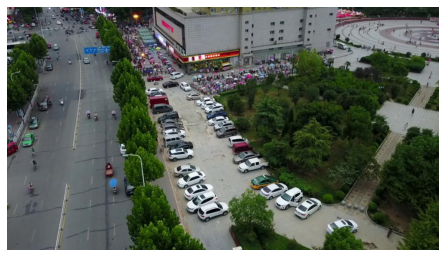

In [9]:
#Visualizing the images
# Create figure and axes
fig = plt.figure(frameon=False)
  
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Display the image
ax.imshow(np_imagetest)



In [10]:
def process_img(jpeg_image):
    #img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    #img = tf.image.resize(img, size= (height ,width))
    return img 

In [11]:
#Define function to create masks for images from corresponding annotation files in VisDrone2019 dataset
#Coded by me https://github.com/ultravioletrad 
def create_mask(image_filepath,anno_filepath): 
    
    path_b=anno_filepath
    path_img=image_filepath

     # extract image id
    image_id = path_img.split('/')[-4:]
    path_mask=image_id[0]+'/'+image_id[1]+'/masks/'+image_id[3]
    data_df = pd.read_csv(path_b, delimiter = ',',header=None)
    
    #<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
    #(x1,y1,w1,h1,sc,cat,tr,oc)= line
     
    data_df.columns=['x1','y1','w1','h1','sc','cat','tr','oc']    
    #print(data_df.info())
    listdf=data_df[['x1','y1','w1','h1']].values.tolist()
    #image_id = path_img.split('/')[-1]
    
    img = PIL.Image.open(path_img)
  
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    np_image = np.array(img)

    # <class 'numpy.ndarray'>
    
    W,H,D= (np_image).shape 
    x = np.zeros(np_image.shape[:-1])+3
    fig, ax = plt.subplots(1)
    for i in range(len(listdf)): 
        [x1,y1,w1,h1]=listdf[i]
        bbox_list=[x1,y1,w1,h1]
    
        bbox=bbox_list
        #print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,
                         edgecolor='r', facecolor="g")
 
        ax.add_patch(rect)
        plt.axis('off')
    
        ax.imshow(x)
    # Create figure and axes
    
    buff=io.BytesIO()
    fig.savefig(buff, format='jpg', dpi='figure')
    buff.seek(0)
    
    img_mask = np.frombuffer(buff.getvalue(), dtype= 'uint8',count= -1, offset=0)
    
    fig.savefig(path_mask, bbox_inches='tight', pad_inches=0)   
    buff.close()
    plt.close(fig) 
    
    mask_arr = PIL.Image.open(path_mask)
    arr = np.array(mask_arr)
    mask_bool=np.where(arr>0,1,0)
    mask=np.ma.MaskedArray(arr,mask_bool)
    im = PIL.Image.fromarray(mask)
    im.save(path_mask)
    mask_arr.close()
    im.close()
    

In [12]:
 
train_dataset_dir = 'Downloads/VisDrone2019-DET-train' 
test_dataset_dir = 'Downloads/VisDrone2019-DET-test-dev'
val_dataset_dir = 'Downloads/VisDrone2019-DET-val'
# define data locations for images and annotations
train_images_dir = train_dataset_dir + '/images/'
train_annotations_dir = train_dataset_dir + '/annotations/'
train_masks_dir = train_dataset_dir + '/masks/'


test_images_dir = test_dataset_dir + '/images/'
test_annotations_dir = test_dataset_dir + '/annotations/'
test_masks_dir = test_dataset_dir + '/masks/'

val_images_dir = val_dataset_dir + '/images/'
val_annotations_dir = val_dataset_dir + '/annotations/'
val_masks_dir = val_dataset_dir + '/masks/'
      


In [13]:
#Explore data dirs
num_images=len(sorted(os.listdir(train_masks_dir)))
print(num_images)


4262


In [14]:

def process_dataset(dataset_dir):
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        masks_dir = dataset_dir + '/masks/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        imgId =[]
        imgPath = []
        maskPath = []
        bboxPath = []
        #for i in range(num_images):
        img_fileslist=list(sorted(os.listdir(images_dir)))
        annotations_fileslist=list(sorted(os.listdir(annotations_dir)))
        for filename in img_fileslist:   
               
               # setting image file
               path_img = images_dir + filename
               path_mask = masks_dir + filename
               # adding images and annotations to dataset
               #self.add_image('dataset', image_id=image_id, path=path_img, annotation= path_bb)
               imgPath.append(path_img)
               maskPath.append(path_mask) 
        for filename in annotations_fileslist:
               # extract image id
               #image_id =  filename[-4:]
                # setting annotations file
               path_bb =  annotations_dir + filename
               bboxPath.append(path_bb)
               #imgId.append(image_id)
           
        return imgPath,bboxPath,maskPath

In [15]:
train_files,trainAnno_files,train_masks = process_dataset(train_dataset_dir)
test_files,testAnno_files,test_masks = process_dataset(test_dataset_dir)
val_files,valAnno_files,val_masks = process_dataset(val_dataset_dir)

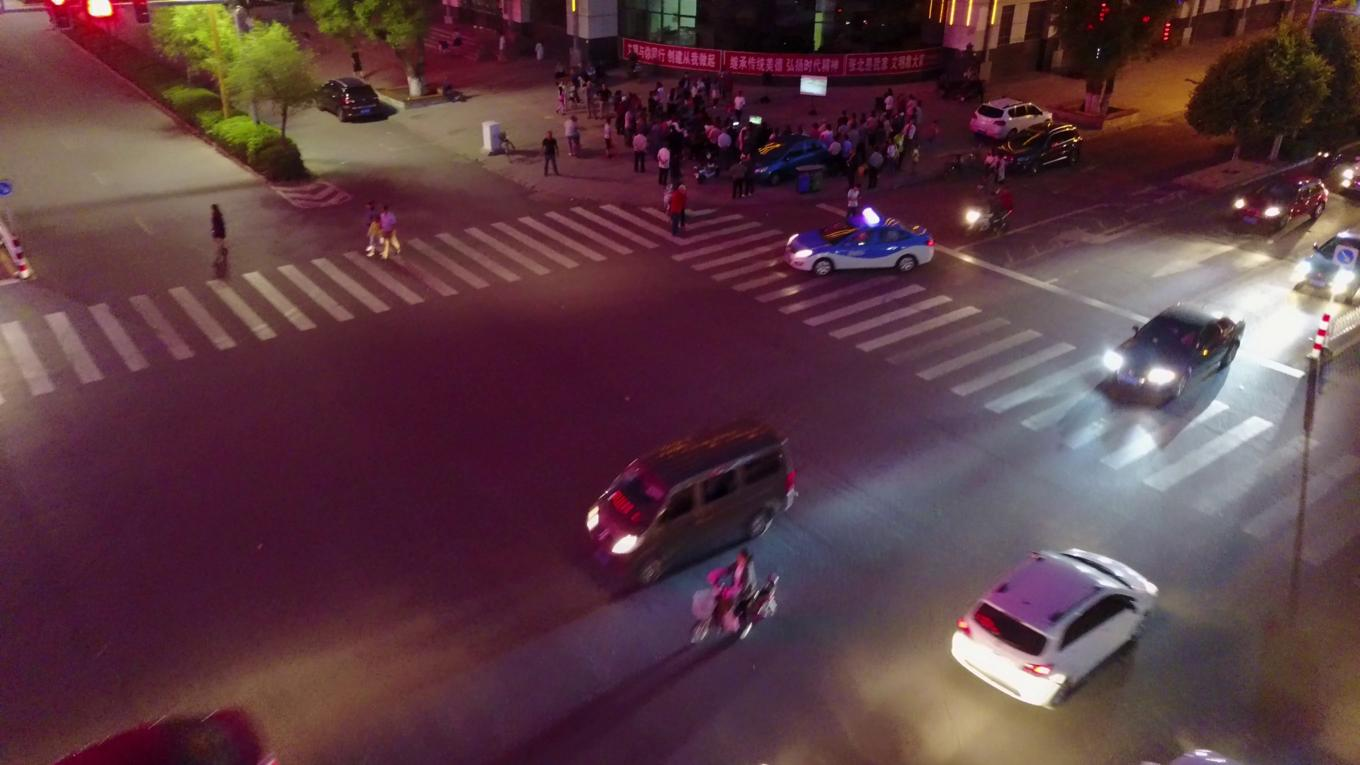

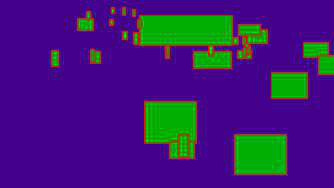

(188, 334, 3)

In [16]:
# Display input image 
display(Image(filename=train_files[77]))
img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(train_masks[77]))
(train_masks[77])
display(img)
np.shape(img)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(train_files[4503:4541],trainAnno_files[4503:4541])):
     create_mask(img_file,anno_file)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(test_files[1590:1610],testAnno_files[1550:1610])):
    create_mask(img_file,anno_file)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(val_files[548:591],valAnno_files[548:591])):
    create_mask(img_file,anno_file)

In [24]:
#Functions to load images & masks to model input
def loadimage(x):
    img = PIL.Image.open(x)
    input_image = img.resize((128,128),PIL.Image.ANTIALIAS)
    input_image=np.asarray(input_image)
    return np.absolute(input_image-0.5)/255
def loadmask(y):
    img = PIL.Image.open(y)
    input_mask= img.resize((128,128),PIL.Image.ANTIALIAS)
    input_mask=np.asarray(input_mask)
    input_mask=np.absolute(input_mask-0.5)/255
    input_mask=np.where((input_mask>=0.00196078) & (input_mask<=0.26470588),0,input_mask)
    input_mask=np.where((input_mask>=0.26470588) & (input_mask<=0.32352941),0,input_mask)
    input_mask=np.where((input_mask>=0.32352941) & (input_mask<=0.35176471),0,input_mask)
    input_mask=np.where(input_mask!=0,1,input_mask)
    return input_mask

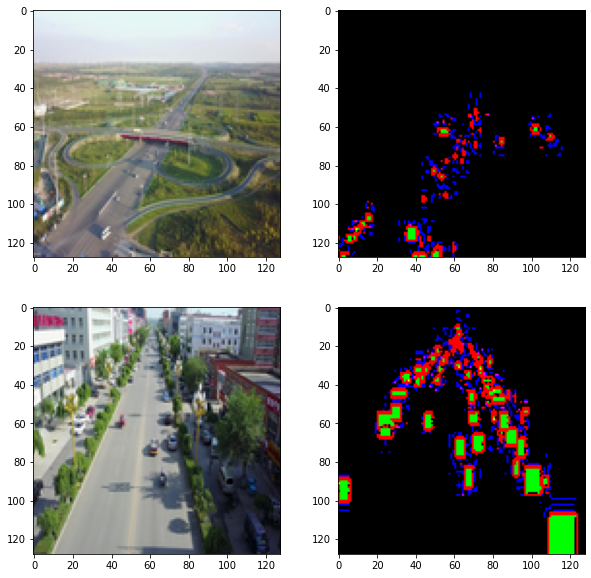

In [25]:
#Check loadimage funtion to load image to model input
sample_image1=loadimage(train_files[780])
sample_mask1=loadmask(train_masks[780])
sample_image2=loadimage(train_files[900])
sample_mask2=loadmask(train_masks[900])
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,2,1)
plt.imshow(sample_image1)
fig.add_subplot(2,2,2)
plt.imshow(sample_mask1)
fig.add_subplot(2,2,3)
plt.imshow(sample_image2)
fig.add_subplot(2,2,4)
plt.imshow(sample_mask2)

(array([[125.,   0.,   0., ...,   0.,   0.,   3.],
        [125.,   0.,   0., ...,   0.,   0.,   3.],
        [126.,   0.,   0., ...,   0.,   0.,   2.],
        ...,
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 128 BarContainer objects>)

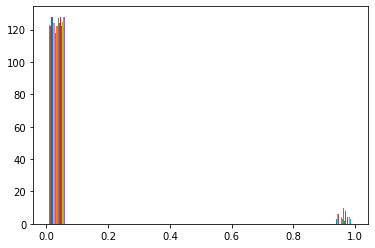

In [26]:
#plot histogram to view
plt.hist(sample_mask1[:,:,0],bins=15)


In [27]:
"""
Image segmentation with a U-Net architecture Using Keras Functional API
"""


'\nImage segmentation with a U-Net architecture Using Keras Functional API\n'

In [28]:
#Code credit François Chollet https://keras.io/examples/vision/oxford_pets_image_segmentation/
class DroneImages(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path_img in enumerate(batch_input_img_paths):
            img = loadimage(path_img)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for j, path_mask in enumerate(batch_target_img_paths):
            img = loadmask(path_mask)
            
            y[j] = img
            # Ground truth labels are  0, 1:
            
        return x, y

In [29]:
train_dataset_images = train_files[0:4500]
train_dataset_masks = train_masks[0:4500]


In [30]:
test_dataset_images = val_files[0:548]
test_dataset_masks = val_masks[0:548]



In [31]:
val_dataset_images = test_files[0:1610]
val_dataset_masks = test_masks[0:1610]


In [32]:

train_size =len(train_dataset_images)
val_size = len(val_dataset_images)
test_size = len(test_dataset_images)


num_examples = train_size + val_size + test_size
print("num_examples:",num_examples)
train_ratio=train_size/num_examples
test_ratio=test_size/num_examples
val_ratio=val_size/num_examples
print("test-train-val-split:")
print("train_size:",train_size, "test_size:",test_size,"val_size:",val_size )
train_length=train_size
test_length=test_size
val_length=val_size
print(f"train_ratio:{train_ratio:.2f}")
print(f"test_ratio:{test_ratio:.2f}")
print(f"val_ratio:{val_ratio:.2f}")
batch_size = 6
buffer_size = 10
STEPS_PER_EPOCH = int(train_size // batch_size)
print("Steps per Epoch",STEPS_PER_EPOCH)
EPOCHS = 10

VALIDATION_STEPS = val_size//batch_size
print("Validation Steps:",VALIDATION_STEPS)
VAL_SUBSPLITS = 1

num_examples: 6658
test-train-val-split:
train_size: 4500 test_size: 548 val_size: 1610
train_ratio:0.68
test_ratio:0.08
val_ratio:0.24
Steps per Epoch 750
Validation Steps: 268


In [33]:
img_size =(128,128)
# Instantiate data Sequences for each split
train_gen = DroneImages(batch_size, img_size, train_dataset_images, train_dataset_masks)
val_gen = DroneImages(batch_size, img_size, val_dataset_images, val_dataset_masks)
test_gen= DroneImages(batch_size, img_size, test_dataset_images, test_dataset_masks)

In [34]:
#Code credit Margaret Maynard-Reid
#https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
#U-Net Image Segmentation in Keras

In [44]:
def double_conv_block(x,n_filters):
    
    #Conv2D then ReLU activation
    #kernel_initializer="he_normal"
    x = layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
    #Conv2D then ReLU activation
    #kernel_initializer="he_normal"
    x = layers.Conv2D(n_filters,3,padding="same",activation="relu")(x)
    
    return x

In [ ]:
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
#https://keras.io/api/layers/regularization_layers/dropout/



In [45]:
def downsample_block(x,n_filters):
    
    f = double_conv_block(x,n_filters)
    p = layers.MaxPool2D(2)(f)
    #p = layers.Dropout(0.3)(p)
    
    return f,p

In [46]:
def upsample_block(x,conv_features,n_filters):
    #upsample https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
    x = layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
    #Concatenate
    x = layers.concatenate([x,conv_features])
    #dropout
    #x = layers.Dropout(0.3)(x)
    #Conv2D twice with ReLU activation
    x = double_conv_block(x,n_filters)
    
    return x

In [47]:
#Build the U-Net Model

def unet_model_arch():
        
        #inputs
        inputs = layers.Input(shape=(128,128,3))

        #encoder :Compacting - Downsample
        #1- downsample
        f1, p1 = downsample_block(inputs,64)
        #2- downsample
        f2 ,p2 = downsample_block(p1,128)
        #3- downsample
        f3, p3 = downsample_block(p2,256)
        #4- downsample
        f4 ,p4 = downsample_block(p3,512)

        #Transition
        features = double_conv_block(p4,1024)

        #decoder: expanding-upsample

        #6-upsample
        us6 = upsample_block(features,f4,512)

        #7-upsample
        us7 = upsample_block(us6,f3,256)

        #8-upsample
        us8 = upsample_block(us7,f2,128)

        #9-upsample
        us9 = upsample_block(us8,f1,64)

        #outputs
        outputs = layers.Conv2D(3,1,padding="same",activation="softmax")(us9)

        #U-Net Model with Keras Functional API
        unet_model = tf.keras.Model(inputs,outputs,name="U-Net")
        
        return unet_model

In [48]:
unet_model = unet_model_arch()

In [49]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
______________________________________________________________________________________________

In [50]:

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

callbacks =[tf.keras.callbacks.ModelCheckpoint("landmine_area_segment.h5",save_best_only= True)]

In [51]:
train_preds = unet_model.predict(train_gen)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


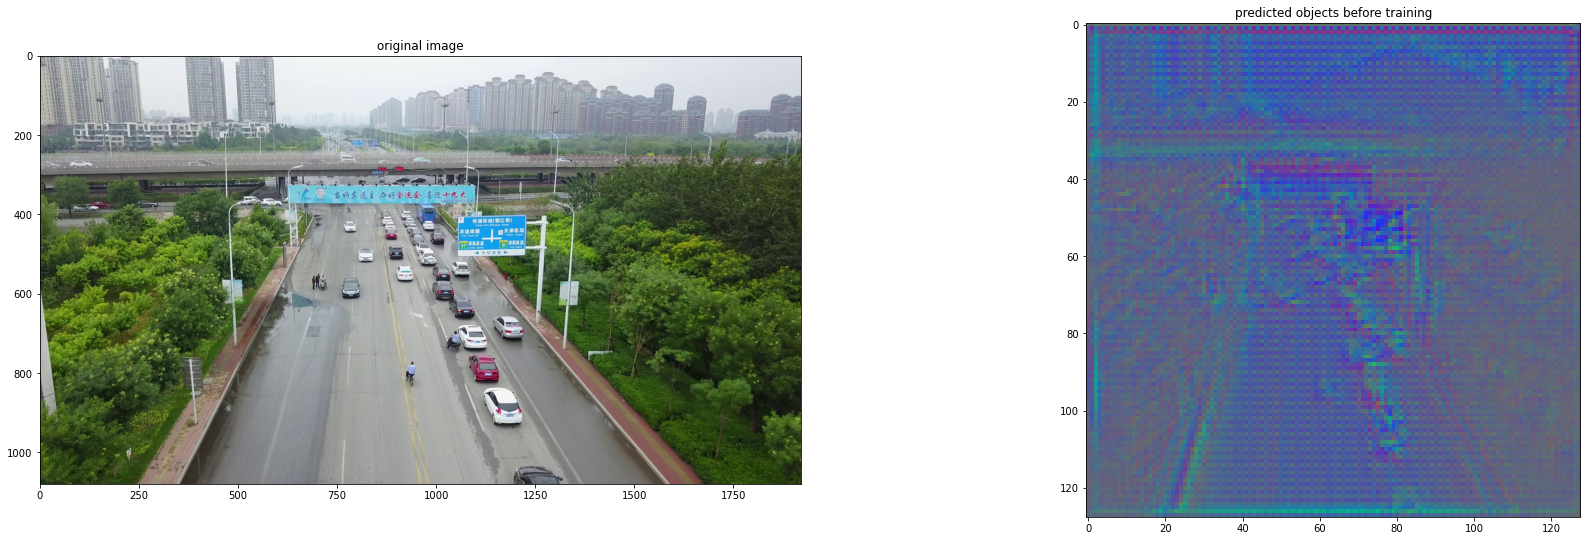

In [68]:
 """Check if the model is predicting correctly before training."""
def display_mask(i):
   
    pred_mask = train_preds[i]
    #pred_mask = tf.argmax(pred_mask, axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]
    #mask = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))
    pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
    plt.imshow(pred_mask)
    #display(pred_mask)
   
i=540

# Display input image
#display(Image(filename=train_dataset_images[i]))
img = PIL.Image.open(train_dataset_images[i])
#display(img)
# Display ground-truth target mask
#img = PIL.ImageOps.autocontrast(keras.preprocessing.image.load_img(test_dataset_masks[i]))
msk = PIL.Image.open(train_dataset_masks[i])
#display(msk)


# Display mask predicted by U-Net model before training
#display_mask(i) 
fig = plt.figure(figsize =(30,20))
fig.tight_layout()
fig.add_subplot(2,2,1).set_title('original image')
plt.imshow(img)
fig.add_subplot(2,2,2).set_title('predicted objects before training')
display_mask(i)


In [54]:

model_history=unet_model.fit(train_gen,
                epochs= 10,
                batch_size=batch_size,
                validation_data=val_gen,callbacks=callbacks)




Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
750/750 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.4946WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x93b46c1f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

In [55]:
test_preds = unet_model.predict(test_gen)


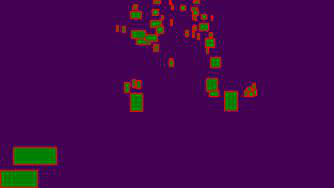

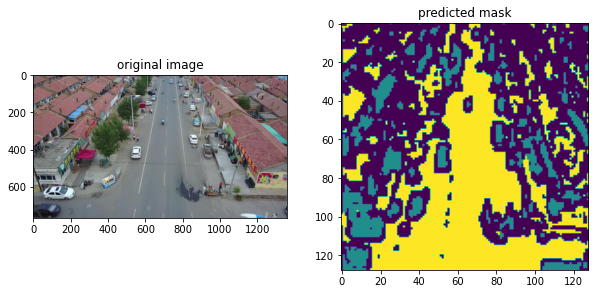

In [72]:
 """display U-Net model's prediction."""
def display_mask(i):
    pred_mask = test_preds[i]
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    #print(pred_mask)
    pred_mask = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))
    #display(mask)
    #pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
    plt.imshow(pred_mask)
    #display(mask)
   
   
i=200

# Display input image
img= PIL.Image.open(test_dataset_images[i])
#display(img)
# Display ground-truth target mask
#img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(test_dataset_masks[i]))
msk = PIL.Image.open(test_dataset_masks[i])
display(msk)

# Display mask predicted by U-Net model after training on VisDrone2019 dataset
#display_mask(i) 
fig = plt.figure(figsize =(10,10))
fig.tight_layout()
fig.add_subplot(2,2,1).set_title('original image')
plt.imshow(img)
fig.add_subplot(2,2,2).set_title('predicted mask')
display_mask(i)


In [73]:
# print(model_history.history.keys())
print(model_history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


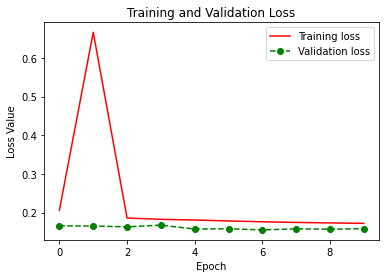

In [74]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epoch_num = model_history.epoch

plt.plot(epoch_num, loss, 'r', label='Training loss')
plt.plot(epoch_num, val_loss, 'go--', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()

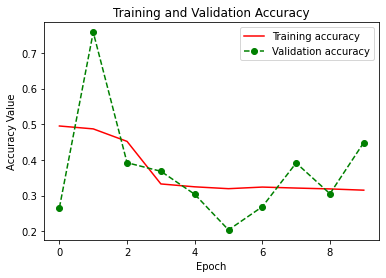

In [75]:
plt.plot(epoch_num, accuracy, 'r', label='Training accuracy')
plt.plot(epoch_num, val_accuracy, 'go--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Training and Validation Accuracy')
plt.legend()

In [76]:
print(model_history.history.keys())
print(model_history.epoch)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [77]:
results = unet_model.evaluate(test_gen, batch_size=batch_size)

91/91 [==============================] - 27s 288ms/step - loss: 0.1911 - accuracy: 0.4494


In [78]:
print("test loss, test accuracy:", results)

test loss, test accuracy: [0.1910826414823532, 0.4493825137615204]


In [131]:
masks_ds=list((os.listdir('Downloads/testimages/masks/')))
images_ds=list((os.listdir('Downloads/testimages/images/')))
imagesdir = 'Downloads/testimages/images/'
masksdir = 'Downloads/testimages/masks/'
print(len(masksdir))
print(len(imagesdir))
test2_dir='Downloads/testimages'

27
28


In [132]:
print(masks_ds[1])

mine_mask78.JPEG


In [133]:
imgPath=[] 
for filename in sorted(images_ds):   

                   # setting image file
                   path_img = imagesdir + filename
                   #path_mask = masksdir + filename
                   # adding images and annotations to dataset
                   #self.add_image('dataset', image_id=image_id, path=path_img, annotation= path_bb)
                   imgPath.append(path_img)
                   #maskPath.append(path_mask) 
maskPath=[]                
for filename in sorted(masks_ds):   

                   # setting image file
                   #path_img = imagesdir + filename
                   path_mask = masksdir + filename
                   # adding images and annotations to dataset
                   #self.add_image('dataset', image_id=image_id, path=path_img, annotation= path_bb)
                   #imgPath.append(path_img)
                   maskPath.append(path_mask)
    
                 


In [134]:
print(imgPath[1])
print(type(imgPath[1]))

Downloads/testimages/images/.ipynb_checkpoints
<class 'str'>


In [135]:
print("Number of samples:", len(maskPath))


Number of samples: 97


In [136]:
img2_size=(128,128)
batch_size=1
test2_gen = DroneImages(batch_size, img2_size, imgPath[2:100], maskPath[2:100])

In [137]:
test2_preds=unet_model.predict(test2_gen)

ground-truth target image


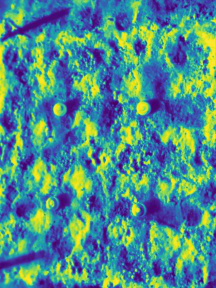

Landmines area predicted/detected by the model


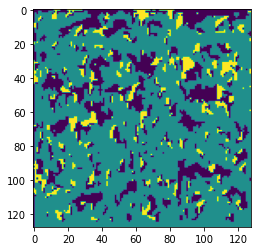

In [143]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    
    pred_mask = test2_preds[i]
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    #print(pred_mask)
    #pred_mask = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))
    #display(mask)
    pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
    plt.imshow(pred_mask)
i=9

# Display ground-truth target image
img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(imgPath[i]))
print("ground-truth target image")
display(img)



# Display ground-truth target mask
#img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(maskPath[i]))
#print("ground-truth target mask")
#display(img)

# Display mask predicted by the U-Net model on LaNDMINE THERMAL IMAGE SERIES Dataset
print("Landmines area predicted/detected by the model")
display_mask(i) 